In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar CSV usando separador correto
df = pd.read_csv("/content/dados.csv", sep=";")

# Padronização de colunas (ajustando os nomes reais do CSV)
for col in ["cidade_origem", "cidade_destino", "rota_completa", "cidade_origem_volta", "cidade_destino_volta", "empresa_onibus_ida", "empresa_onibus_volta"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Conversão de datas
if "data_compra" in df.columns:
    df["data_compra"] = pd.to_datetime(df["data_compra"], errors="coerce", dayfirst=True)
    df["ano"] = df["data_compra"].dt.year
    df["mes"] = df["data_compra"].dt.month
    df["dia_semana"] = df["data_compra"].dt.dayofweek

# Conversão de valores numéricos
if "qtd_passagens" in df.columns:
    df["qtd_passagens"] = pd.to_numeric(df["qtd_passagens"], errors="coerce").fillna(1).astype(int)

if "valor_compra" in df.columns:
    df["valor_compra"] = pd.to_numeric(df["valor_compra"], errors="coerce")
    df["ticket_medio_por_passageiro"] = np.where(
        df["qtd_passagens"] > 0,
        df["valor_compra"] / df["qtd_passagens"],
        np.nan
    )

# Criar rota
if "cidade_origem" in df.columns and "cidade_destino" in df.columns:
    df["rota_ida"] = df["cidade_origem"] + " -> " + df["cidade_destino"]

df.head(10)


id_compra  id_cliente data_compra   cidade_origem  cidade_destino  \
0      10016        1001  2023-06-11          recife  belo horizonte   
1      10011        1001  2024-05-12  rio de janeiro       fortaleza   
2      10014        1001  2024-10-07        salvador        curitiba   
3      10015        1001  2025-03-16  belo horizonte        salvador   
4      10012        1001  2025-04-17  belo horizonte    porto alegre   
5      10013        1001  2025-06-15          manaus        brasilia   
6      10022        1002  2023-06-10       sao paulo        curitiba   
7      10023        1002  2024-09-03          manaus        curitiba   
8      10021        1002  2025-01-08          manaus       fortaleza   
9      10032        1003  2023-03-16        curitiba       sao paulo   

  cidade_origem_volta cidade_destino_volta   empresa_onibus_ida  \
0           sem volta            sem volta       rápido federal   
1           sem volta            sem volta       rápido federal   
2           sem volta            sem volta        viacao cometa   
3           sem volta            sem volta                pluma   
4           sem volta            sem volta  expresso brasileiro   
5           sem volta            sem volta  expresso brasileiro   
6           sem volta            sem volta           itapemirim   
7           sem volta            sem volta      expresso do sul   
8           sem volta            sem volta                pluma   
9           sem volta            sem volta         águia branca   

  empresa_onibus_volta  valor_compra  qtd_passagens  \
0            sem volta        213.84              1   
1            sem volta        176.14              1   
2            sem volta         59.27              1   
3            sem volta         44.08              1   
4            sem volta        235.05              1   
5            sem volta         41.01              1   
6            sem volta         75.63              1   
7            sem volta        242.88              1   
8            sem volta        194.69              1   
9            sem volta         75.78              1   

                      rota_completa  ticket_medio   ano  mes  dia_semana  \
0        recife para belo horizonte        213.84  2023    6           6   
1     rio de janeiro para fortaleza        176.14  2024    5           6   
2            salvador para curitiba         59.27  2024   10           0   
3      belo horizonte para salvador         44.08  2025    3           6   
4  belo horizonte para porto alegre        235.05  2025    4           3   
5              manaus para brasilia         41.01  2025    6           6   
6           sao paulo para curitiba         75.63  2023    6           5   
7              manaus para curitiba        242.88  2024    9           1   
8             manaus para fortaleza        194.69  2025    1           2   
9           curitiba para sao paulo         75.78  2023    3           3   

   ticket_medio_por_passageiro                        rota_ida  
0                       213.84        recife -> belo horizonte  
1                       176.14     rio de janeiro -> fortaleza  
2                        59.27            salvador -> curitiba  
3                        44.08      belo horizonte -> salvador  
4                       235.05  belo horizonte -> porto alegre  
5                        41.01              manaus -> brasilia  
6                        75.63           sao paulo -> curitiba  
7                       242.88              manaus -> curitiba  
8                       194.69             manaus -> fortaleza  
9                        75.78           curitiba -> sao paulo

In [173]:
print("\nResumo numérico:\n",
      df[["valor_compra","qtd_passagens","ticket_medio_por_passageiro"]].describe().round(2))



Resumo numérico:
        valor_compra  qtd_passagens  ticket_medio_por_passageiro
count       1983.00        1983.00                      1983.00
mean         144.39           1.26                       129.18
std           60.16           0.63                        63.89
min           40.16           1.00                         8.16
25%           93.86           1.00                        74.95
50%          145.65           1.00                       121.32
75%          195.41           1.00                       184.62
max          249.94           5.00                       249.79


In [174]:
# Top Rotas por Volume (Quantidade de compras)
top_rotas = (
    df.groupby("rota_completa", dropna=False)
      .agg(
          qtd_compras=("id_compra","count"),
          receita=("valor_compra","sum"),
          ticket_medio=("ticket_medio_por_passageiro","mean")
      )
      .round(2)
      .sort_values("qtd_compras", ascending=False)
      .head(10)
)

top_rotas


qtd_compras  receita  ticket_medio
rota_completa                                                         
belo horizonte para manaus                   32  4735.80        135.17
belo horizonte para recife                   31  4973.29        140.27
curitiba para brasilia                       31  4115.48        125.53
rio de janeiro para fortaleza                31  4678.93        134.05
sao paulo para brasilia                      31  4842.93        142.57
sao paulo para fortaleza                     31  4809.33        129.61
brasilia para manaus                         30  3681.14        108.82
manaus para brasilia                         29  3647.64        122.20
belo horizonte para rio de janeiro           28  4172.49        125.45
curitiba para rio de janeiro                 28  4073.03        127.97

In [175]:
# Gráfico Top 10 rotas
plt.figure(figsize=(10,5))
top_rotas["qtd_compras"].sort_values(ascending=True).plot(kind="barh")
plt.title("Top 10 Rotas por Quantidade de Compras")
plt.xlabel("Quantidade de Compras")
plt.ylabel("Rota")
plt.tight_layout()
plt.show()

In [176]:
empresas = (
    df.groupby("empresa_onibus_ida", dropna=False)
      .agg(
          qtd_compras=("id_compra","count"),
          receita=("valor_compra","sum"),
          ticket_medio=("ticket_medio_por_passageiro","mean")
      )
      .round(2)
      .sort_values(["qtd_compras","receita"], ascending=False)
      .head(10)
)

empresas


qtd_compras   receita  ticket_medio
empresa_onibus_ida                                      
viacao 1001                  209  31320.36        132.49
expresso do sul              207  30723.66        135.11
itapemirim                   203  27853.26        119.92
pluma                        202  30144.14        135.77
viacao cometa                199  28455.70        125.13
kaissara                     197  29364.98        131.09
expresso brasileiro          193  28790.15        135.38
rápido federal               192  27478.72        127.29
penha                        191  25997.46        124.63
águia branca                 190  26189.75        124.44

In [177]:
# Grafico: Top empresas por volume
plt.figure(figsize=(10,5))
empresas["qtd_compras"].sort_values(ascending=True).plot(kind="barh")
plt.title("Top 10 Empresas por Quantidade de Compras")
plt.xlabel("Quantidade de Compras")
plt.ylabel("Empresa")
plt.tight_layout()
plt.show()

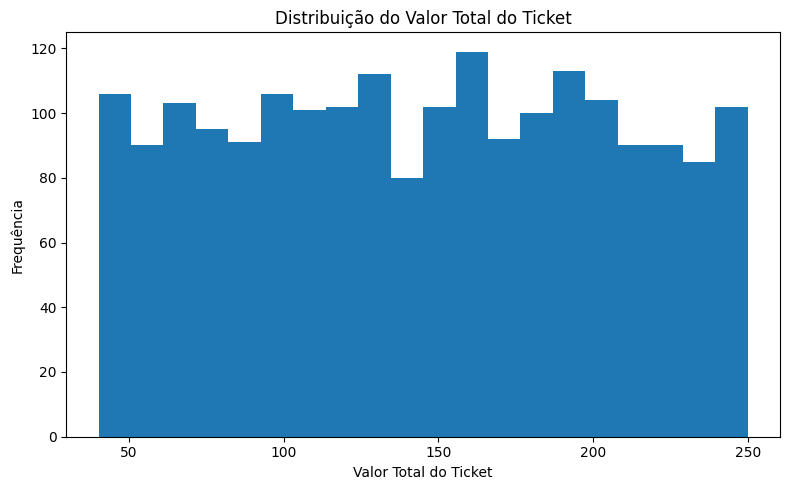

In [178]:
# Distribuição de Preços (Valor total do ticket)
plt.figure(figsize=(8,5))
df["valor_compra"].plot(kind="hist", bins=20)
plt.title("Distribuição do Valor Total do Ticket")
plt.xlabel("Valor Total do Ticket")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


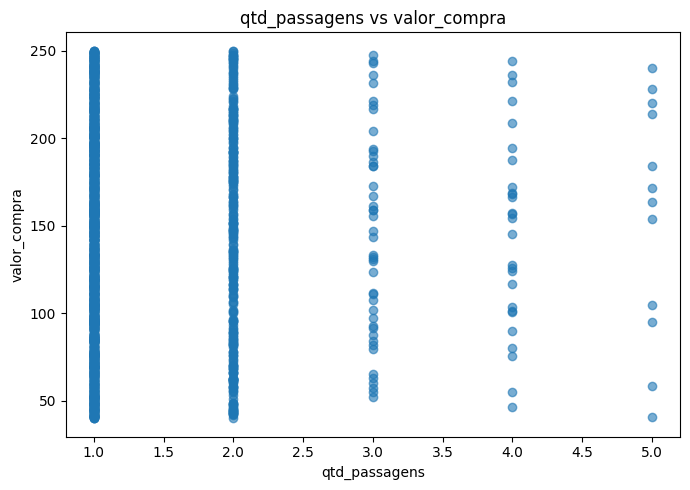

In [179]:
# Relação entre Quantidade de Passagens e Valor Total
plt.figure(figsize=(7,5))
plt.scatter(df["qtd_passagens"], df["valor_compra"], alpha=0.6)
plt.title("qtd_passagens vs valor_compra")
plt.xlabel("qtd_passagens")
plt.ylabel("valor_compra")
plt.tight_layout()
plt.show()

In [180]:
# Sazonalidade de Compras (por Mês)
compras_mes = df.groupby("mes")["id_compra"].count().reindex(range(1,13)).fillna(0)

plt.figure(figsize=(8,4))
compras_mes.plot(kind="line", marker="o")
plt.title("Quantidade de Compras por Mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade de Compras")
plt.tight_layout()
plt.show()

compras_mes.to_frame(name="qtd_compras")

qtd_compras
mes             
1            188
2            175
3            168
4            162
5            162
6            161
7            155
8            171
9            154
10           155
11           160
12           172

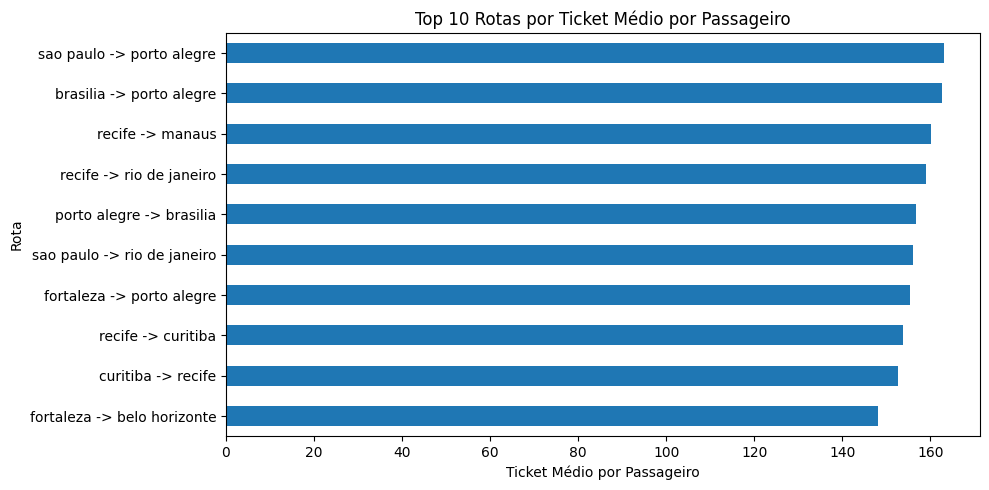

valor_ticket_por_passageiro
rota_ida                                                
sao paulo -> porto alegre                     163.131176
brasilia -> porto alegre                      162.711667
recife -> manaus                              160.176562
recife -> rio de janeiro                      159.004792
porto alegre -> brasilia                      156.733125
sao paulo -> rio de janeiro                   156.098571
fortaleza -> porto alegre                     155.490889
recife -> curitiba                            153.788261
curitiba -> recife                            152.760750
fortaleza -> belo horizonte                   148.048529

In [181]:
# Ticket Médio por Passageiro (Top 10 Rotas)
ticket_rotas = (
    df.groupby("rota_ida")["ticket_medio_por_passageiro"]
      .mean()
      .dropna()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10,5))
ticket_rotas.sort_values(ascending=True).plot(kind="barh")
plt.title("Top 10 Rotas por Ticket Médio por Passageiro")
plt.xlabel("Ticket Médio por Passageiro")
plt.ylabel("Rota")
plt.tight_layout()
plt.show()

ticket_rotas.to_frame(name="valor_ticket_por_passageiro")

In [182]:
# Adicionando a sigla de cada estado por meio de um dicionário
map_cidade_estado = {
    "sao paulo": "SP",
    "rio de janeiro": "RJ",
    "belo horizonte": "MG",
    "salvador": "BA",
    "recife": "PE",
    "curitiba": "PR",
    "porto alegre": "RS",
    "brasilia": "DF",
    "fortaleza": "CE",
    "manaus": "AM"
}

df["estado_origem"] = df["cidade_origem"].map(map_cidade_estado)


In [183]:
# Total de pedidos por cliente
freq_cliente = df.groupby("id_cliente")["id_compra"].count()
freq_cliente.sort_values(ascending=False)

id_cliente
1001    6
1479    6
1467    6
1475    6
1394    6
       ..
1050    2
1453    2
1461    2
1463    2
1025    2
Name: id_compra, Length: 500, dtype: int64

In [184]:
# Atribuindo níveis para cada cliente (frequência) por meio de quantis
freq_cliente = df.groupby("id_cliente")["id_compra"].count().reset_index(name="num_compras")
q1 = freq_cliente["num_compras"].quantile(0.25)
q3 = freq_cliente["num_compras"].quantile(0.75)

def classificar_frequencia(x):
    if x >= q3:
        return "Alta"
    elif x >= q1:
        return "Media"
    else:
        return "Baixa"

freq_cliente["segmento_freq"] = freq_cliente["num_compras"].apply(classificar_frequencia)
freq_cliente.head()

id_cliente  num_compras segmento_freq
0        1001            6          Alta
1        1002            3         Media
2        1003            2         Baixa
3        1004            4         Media
4        1005            2         Baixa

In [185]:
from datetime import timedelta

# Definir "hoje" como um dia após a última data do dataset

hoje = df["data_compra"].max() + pd.Timedelta(days=1)

# Calcular recência em dias
recencia_cliente = (df.groupby("id_cliente")["data_compra"]
                      .max()
                      .reset_index())
recencia_cliente["recencia_dias"] = (hoje - recencia_cliente["data_compra"]).dt.days

In [186]:
# Atribuindo níveis para cada cliente (recência)
def classificar_recencia(x):
    if x <= 30:
        return "Alta"
    elif x <= 60:
        return "Media"
    else:
        return "Baixa"

recencia_cliente["segmento_recencia"] = recencia_cliente["recencia_dias"].apply(classificar_recencia)
del recencia_cliente["data_compra"]


In [187]:
top_rotas = (df.groupby(["id_cliente","cidade_origem", "cidade_destino", "valor_compra", "data_compra"])
               .size()
               .reset_index(name="qtd")
               .sort_values(["id_cliente","qtd"], ascending=[True,False]))

# Selecionar top 3
top_rotas = top_rotas.groupby("id_cliente").head(3)

In [188]:
# Merge frequencia + estado + recencia + top_rotas
estado_cliente = df.groupby("id_cliente")["estado_origem"].first().reset_index()

tabela_final = (freq_cliente
                .merge(estado_cliente, on="id_cliente", how="left")
                .merge(recencia_cliente, on="id_cliente", how="left")
                .merge(top_rotas, on="id_cliente", how="left"))

tabela_final = tabela_final[["id_cliente", "estado_origem", "segmento_freq", "data_compra", "recencia_dias", "segmento_recencia", "cidade_origem", "cidade_destino", "valor_compra","qtd"]]
# tabela_final = tabela_final.rename(columns={"data_compra_x": "data_compra"})

tabela_final.sort_values('id_cliente', ascending=False).head(10)

id_cliente estado_origem segmento_freq data_compra  recencia_dias  \
1391        1500            SP         Baixa  2024-02-03             60   
1390        1500            SP         Baixa  2025-11-02             60   
1389        1499            BA         Media  2023-06-08            266   
1387        1499            BA         Media  2025-04-10            266   
1388        1499            BA         Media  2024-02-08            266   
1386        1498            BA          Alta  2024-12-26            124   
1384        1498            BA          Alta  2025-08-30            124   
1385        1498            BA          Alta  2025-08-02            124   
1381        1497            RS          Alta  2023-07-12              7   
1383        1497            RS          Alta  2024-11-13              7   

     segmento_recencia   cidade_origem  cidade_destino  valor_compra  qtd  
1391             Media       sao paulo          manaus        138.86    1  
1390             Media        curitiba        salvador        123.06    1  
1389             Baixa        salvador  belo horizonte        240.18    1  
1387             Baixa          manaus  belo horizonte        104.98    1  
1388             Baixa          recife  rio de janeiro         78.05    1  
1386             Baixa  rio de janeiro  belo horizonte        159.01    1  
1384             Baixa          manaus          recife         82.53    1  
1385             Baixa          recife       sao paulo         73.53    1  
1381              Alta        brasilia        salvador        118.66    1  
1383              Alta          manaus        brasilia        183.64    1

In [189]:
# Probabilidade de destinos por segmento (freq x recência)
destinos_segmento = (
    tabela_final.groupby(["segmento_freq", "segmento_recencia", "cidade_destino"])
    .size()
    .reset_index(name="freq")
)
destinos_segmento["prob"] = destinos_segmento.groupby(
    ["segmento_freq", "segmento_recencia"]
)["freq"].transform(lambda x: x / x.sum())

print("\nProbabilidade de destinos por segmento:\n")
print(destinos_segmento.sort_values(["segmento_freq", "segmento_recencia", "prob"],
                                    ascending=[True, True, False]))


Probabilidade de destinos por segmento:

   segmento_freq segmento_recencia  cidade_destino  freq      prob
4           Alta              Alta          manaus    16  0.144144
7           Alta              Alta  rio de janeiro    16  0.144144
5           Alta              Alta    porto alegre    15  0.135135
0           Alta              Alta  belo horizonte    12  0.108108
1           Alta              Alta        brasilia    12  0.108108
..           ...               ...             ...   ...       ...
79         Media             Media          recife     3  0.083333
80         Media             Media  rio de janeiro     3  0.083333
82         Media             Media       sao paulo     3  0.083333
76         Media             Media       fortaleza     2  0.055556
77         Media             Media          manaus     1  0.027778

[83 rows x 5 columns]


In [190]:

# Estimar próxima compra por cliente
ultima_compra = tabela_final.groupby("id_cliente")["data_compra"].max().reset_index()
ultima_compra = ultima_compra.merge(
    tabela_final[["id_cliente", "segmento_freq", "segmento_recencia"]],
    on="id_cliente", how="left"
).drop_duplicates("id_cliente")

recencia_cliente


id_cliente  recencia_dias segmento_recencia
0          1001            200             Baixa
1          1002            358             Baixa
2          1003            853             Baixa
3          1004            487             Baixa
4          1005            465             Baixa
..          ...            ...               ...
495        1496             25              Alta
496        1497              7              Alta
497        1498            124             Baixa
498        1499            266             Baixa
499        1500             60             Media

[500 rows x 3 columns]

In [226]:
# calcular a probabilidade da próxima compra eu analiso o intervalo de compra médio
# agrupando por origem, recencia; filtro também compra feita dentro de 1 ano
# um cliente com a mesma origem, recencia e frequencia, assumo que vai ter
# o mesmo intervalo médio

tabela_final['delta_compra'] = 0
# Esse loop serve para CALCULAR O DELTA_COMPRA DE TODOS OS REGISTROS
# Serve também para RECALCULAR O SEGMENTO_RECENCIA
for idx, row in tabela_final.iterrows():
    # Filtra todas as linhas do mesmo cliente e data_compra maior que a minha (e diferente do índice atual)
    futuras = tabela_final[
        (tabela_final['id_cliente'] == row['id_cliente']) &
        (tabela_final['data_compra'] > row['data_compra']) &
        (tabela_final.index != idx)
    ]

    if not futuras.empty:
        # Pega a próxima compra (menor data_compra > minha_data)
        proxima_data = futuras['data_compra'].min()
        delta = (proxima_data - row['data_compra']).days  # .days se for datetime
        tabela_final.at[idx, 'delta_compra'] = delta

        if delta <= 30:
          tabela_final.at[idx, 'segmento_recencia'] = 'Alta'
        elif delta <= 60:
          tabela_final.at[idx, 'segmento_recencia'] = 'Media'
        else:
          tabela_final.at[idx, 'segmento_recencia'] = 'Baixa'

    else:
        tabela_final.at[idx, 'delta_compra'] = None  # Ou 0, ou np.nan, etc

# USO PARA CALCULAR A PREVISÃO EM DIAS PARA A PRÓXIMA COMPRA DE TODOS OS CLIENTES
tabela_final['previsao_delta_compra'] = 0 # TEM A QUANTIDADE DE DIAS PREVISTOS PARA A PRÓXIMA COMPRA DESSE CLIENTE

for idx, row in tabela_final.iterrows():
    # Filtra todas as linhas com mesma cidade_origem, segmento_recencia e segment_freq
    filtro = (
        (tabela_final['cidade_origem'] == row['cidade_origem']) &
        (tabela_final['segmento_recencia'] == row['segmento_recencia']) &
        (tabela_final['delta_compra'] < 365)
    )

    # Calcula a média de delta_compra, ignorando NaN se houver
    media_delta = tabela_final.loc[filtro, 'delta_compra'].mean()
    tabela_final.at[idx, 'previsao_delta_compra'] = media_delta


tabela_final.head(10)

/tmp/ipython-input-2165696187.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46.61538461538461' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tabela_final.at[idx, 'previsao_delta_compra'] = media_delta


id_cliente estado_origem segmento_freq data_compra  recencia_dias  \
0        1001            PE          Alta  2025-04-17            200   
1        1001            PE          Alta  2025-03-16            200   
2        1001            PE          Alta  2025-06-15            200   
3        1002            SP         Media  2024-09-03            358   
4        1002            SP         Media  2025-01-08            358   
5        1002            SP         Media  2023-06-10            358   
6        1003            PR         Baixa  2023-09-01            853   
7        1003            PR         Baixa  2023-03-16            853   
8        1004            AM         Media  2024-09-01            487   
9        1004            AM         Media  2024-02-10            487   

  segmento_recencia   cidade_origem  cidade_destino  valor_compra  qtd  \
0             Media  belo horizonte    porto alegre        235.05    1   
1             Media  belo horizonte        salvador         44.08    1   
2             Baixa          manaus        brasilia         41.01    1   
3             Baixa          manaus        curitiba        242.88    1   
4             Baixa          manaus       fortaleza        194.69    1   
5             Baixa       sao paulo        curitiba         75.63    1   
6             Baixa        curitiba          recife        241.63    1   
7             Baixa        curitiba       sao paulo         75.78    1   
8             Baixa  belo horizonte  rio de janeiro        151.36    1   
9             Baixa        curitiba        brasilia         61.77    1   

   delta_compra  previsao_delta_compra  
0          59.0              46.615385  
1          32.0              46.615385  
2           NaN             193.129630  
3         127.0             193.129630  
4           NaN             193.129630  
5         451.0             189.050000  
6           NaN             185.279412  
7         169.0             185.279412  
8           NaN             209.014925  
9         204.0             185.279412

In [223]:
# PARA CALCULAR A PROBABILIDADE DE PRÓXIMA ROTA
# PEGO TODOS QUE SAIRAM DO MESMO LOCAL.
# POR EXEMPLO QUEM SAIU DO RIO DE JANEIRO FOI PARA ONDE?
#      20 FOI PARA SÃO PAULO
#      12 FOI PARA RECIFE
#      19 FOI PARA MANAUS
# MINHA PREVISÃO DE PRÓXIMA ROTA É SÃO PAULO (MODA)
import statistics

rotas = tabela_final[['cidade_origem', 'cidade_destino']]
proxima_rota = rotas.groupby('cidade_origem')['cidade_destino'].apply(statistics.mode).reset_index(name='proxima_rota_prevista')

print("\nPróxima rota prevista por cidade de origem (moda):\n")
proxima_rota.head(10)


Próxima rota prevista por cidade de origem (moda):



cidade_origem proxima_rota_prevista
0  belo horizonte                manaus
1        brasilia                manaus
2        curitiba              brasilia
3       fortaleza              curitiba
4          manaus              brasilia
5    porto alegre              brasilia
6          recife        belo horizonte
7  rio de janeiro        belo horizonte
8        salvador             fortaleza
9       sao paulo              brasilia